### R2 vs All Regressors Results

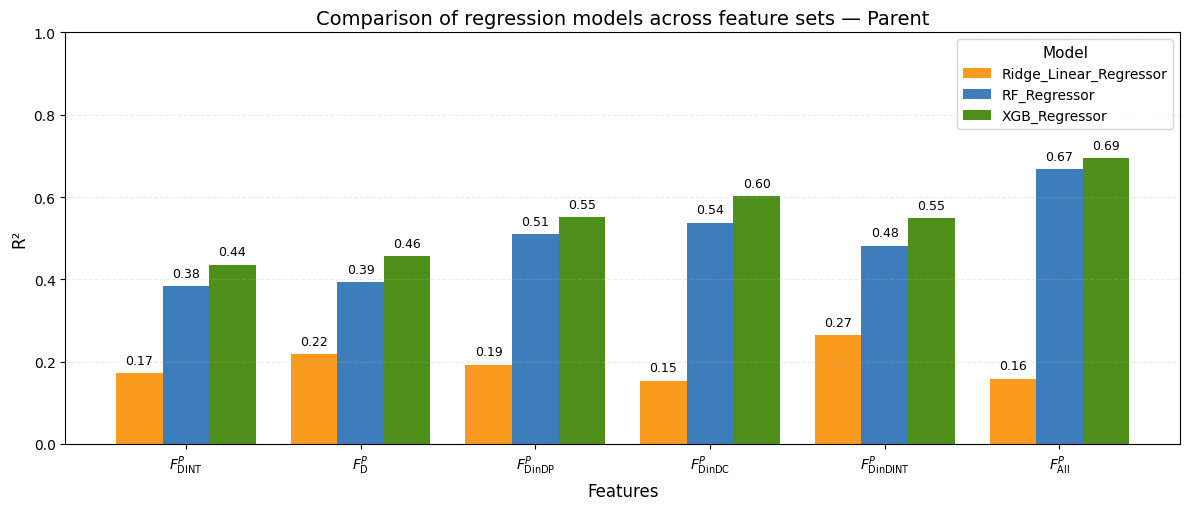

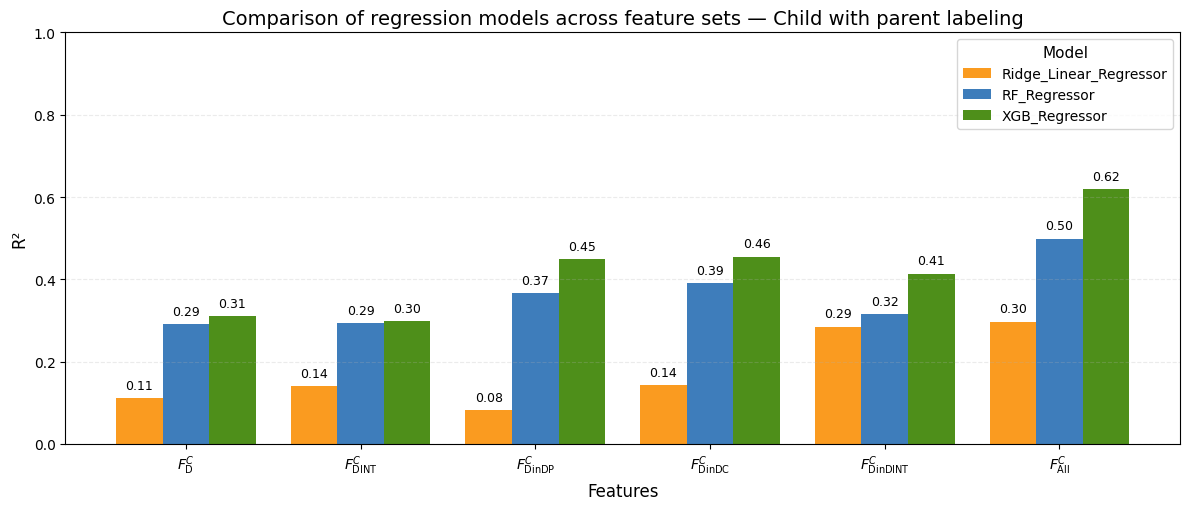

In [24]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import textwrap

# -----------------------------------------------------------
# 1) SET YOUR LOCAL CSV PATH HERE
# -----------------------------------------------------------
# csv_path = r"O:\MyThesis\Project\Code\Michal_Full_Dataset\Regressors_with_plots\Regressors_Results.csv"
csv_path = "Regressors_Results.csv"

# Which metric to plot and error type
metric = "Eval_R2"      # or "CV_R2"
error_type = "se"       # "se" or "ci" (95% CI)

# -----------------------------------------------------------
# 2) LOAD & CLEAN
# -----------------------------------------------------------
df = pd.read_csv(csv_path)
if metric not in df.columns:
    raise ValueError(f"Metric '{metric}' not found. Columns: {df.columns.tolist()}")

df["Model"] = df["Model"].astype(str).str.strip()
df["Dataset"] = df["Dataset"].astype(str).str.strip()

# -----------------------------------------------------------
# 2.1) (OPTIONAL BUT RECOMMENDED) Normalize model names
# If your CSV already uses the three exact names below, this changes nothing.
# -----------------------------------------------------------
model_alias = {
    "RidgeLinear_Regressor": "Ridge_Linear_Regressor",
    "Ridge_Linear_Regressor": "Ridge_Linear_Regressor",
    "Linear_Regressor": "Ridge_Linear_Regressor",
    "Ridge_Regressor" : "Ridge_Linear_Regressor",

    "RandomForest_Regressor": "RF_Regressor",
    "RF_Regressor": "RF_Regressor",

    "XGB_Regressor": "XGB_Regressor",
    "XGBoost_Regressor": "XGB_Regressor",
}
df["Model"] = df["Model"].map(lambda m: model_alias.get(m, m))

# -----------------------------------------------------------
# 3) TAG PARENT vs CHILD USING SUPERSCRIPT {P} or {C}
# -----------------------------------------------------------
def who_group(features_name: str) -> str:
    s = str(features_name).strip()
    if re.search(r"\^\{P\}\$", s):
        return "Parent"
    if re.search(r"\^\{C\}\$", s):
        return "Child"
    return "Other"

df["Who"] = df["Dataset"].apply(who_group)

# -----------------------------------------------------------
# 4) AGGREGATE DUPLICATES (mean, std, se, ci95)
# -----------------------------------------------------------
def aggregate_stats(frame: pd.DataFrame):
    g = (
        frame.groupby(["Dataset", "Model"], as_index=False)[metric]
             .agg(["mean", "std", "count"])
             .reset_index()
             .rename(columns={"mean": "mean_val", "std": "std_val", "count": "n"})
    )

    g["se"] = g.apply(
        lambda r: (r["std_val"] / math.sqrt(r["n"])) if r["n"] > 0 else 0.0,
        axis=1
    )
    g["ci95"] = 1.96 * g["se"]
    g["err"] = g["se"] if error_type.lower() == "se" else g["ci95"]
    return g

agg_all = aggregate_stats(df)

# -----------------------------------------------------------
# 5) TEXT WRAP HELPER
# -----------------------------------------------------------
def wrap_labels(labels, width=18):
    return ["\n".join(textwrap.wrap(str(lab), width=width, break_long_words=False))
            for lab in labels]

# -----------------------------------------------------------
# 6) PLOT FUNCTION — FORCE BAR ORDER: Linear (left), RF (middle), XGB (right)
# -----------------------------------------------------------
def plot_subset(agg: pd.DataFrame, who: str, title_suffix: str):

    sub_feats = df.loc[df["Who"] == who, "Dataset"].unique().tolist()
    if not sub_feats:
        print(f"[info] No features for {who}")
        return

    sub = agg[agg["Dataset"].isin(sub_feats)].copy()
    if sub.empty:
        print(f"[info] No aggregated data for {who}")
        return

    # ---- IMPORTANT: These MUST match your CSV model names ----
    preferred_model_order = [
        "Ridge_Linear_Regressor",  # LEFT  (Linear)
        "RF_Regressor",            # MIDDLE (RF)
        "XGB_Regressor",           # RIGHT (XGB)
    ]

    # keep only models actually present, in that order
    model_levels = [m for m in preferred_model_order if m in sub["Model"].unique()]

    # append any extra models if they exist
    model_levels += [m for m in sub["Model"].unique() if m not in model_levels]

    sub["Model"] = pd.Categorical(sub["Model"], categories=model_levels, ordered=True)

    # ---- SORT FEATURES BY MEAN VALUE (keeps your old behavior) ----
    by_feat = sub.groupby("Dataset", as_index=False)["mean_val"].mean()
    order = by_feat.sort_values("mean_val", ascending=True)["Dataset"].tolist()
    sub["Dataset"] = pd.Categorical(sub["Dataset"], categories=order, ordered=True)

    pivot_mean = sub.pivot(index="Dataset", columns="Model", values="mean_val").reindex(order)
    pivot_err  = sub.pivot(index="Dataset", columns="Model", values="err").reindex(order)

    # ---- Colors: keys MUST match model names ----
    color_map = {
        "Ridge_Linear_Regressor": "#fa930deb",  # linear
        "RF_Regressor": "#3e7dbb",              # RF
        "XGB_Regressor": "#4E8F1A",             # XGB
    }

    # ---- PLOT ----
    plt.figure(figsize=(12, 6))
    x = np.arange(len(order))
    width = 0.8 / len(model_levels)

    # Plot in model_levels order => controls LEFT/MIDDLE/RIGHT + legend order
    for i, model in enumerate(model_levels):
        means = pivot_mean[model].values if model in pivot_mean.columns else np.zeros(len(order))
        errs  = pivot_err[model].values if model in pivot_err.columns else np.zeros(len(order))

        # offsets: i=0 left, i=1 middle, i=2 right
        offset = (i - (len(model_levels) - 1) / 2) * width

        plt.bar(
            x + offset,
            means,
            width,
            label=model,
            color=color_map.get(model, None),
            yerr=errs,
            ecolor="black",
            capsize=4,
        )

        for xi, val in zip(x + offset, means):
            if not np.isnan(val):
                plt.text(xi, val + 0.015, f"{val:.2f}",
                         ha="center", va="bottom", fontsize=9)

    plt.xticks(x, wrap_labels(order, width=25), fontsize=10)
    plt.ylabel("R²", fontsize=12)
    plt.xlabel("Features", fontsize=12)
    plt.ylim(0, 1.0)
    plt.title(f"Comparison of regression models across feature sets — {title_suffix}", fontsize=14)

    # legend order follows plotting order now (Linear, RF, XGB)
    plt.legend(title="Model", fontsize=10, title_fontsize=11, frameon=True)
    plt.grid(axis="y", linestyle="--", alpha=0.25)
    plt.tight_layout()
    plt.gcf().subplots_adjust(bottom=0.25)
    plt.show()

# -----------------------------------------------------------
# 7) CREATE PARENT + CHILD PLOTS
# -----------------------------------------------------------
plot_subset(agg_all, who="Parent", title_suffix="Parent")
plot_subset(agg_all, who="Child",  title_suffix="Child with parent labeling")


✔ Residual histogram saved to:
residual_distribution.png


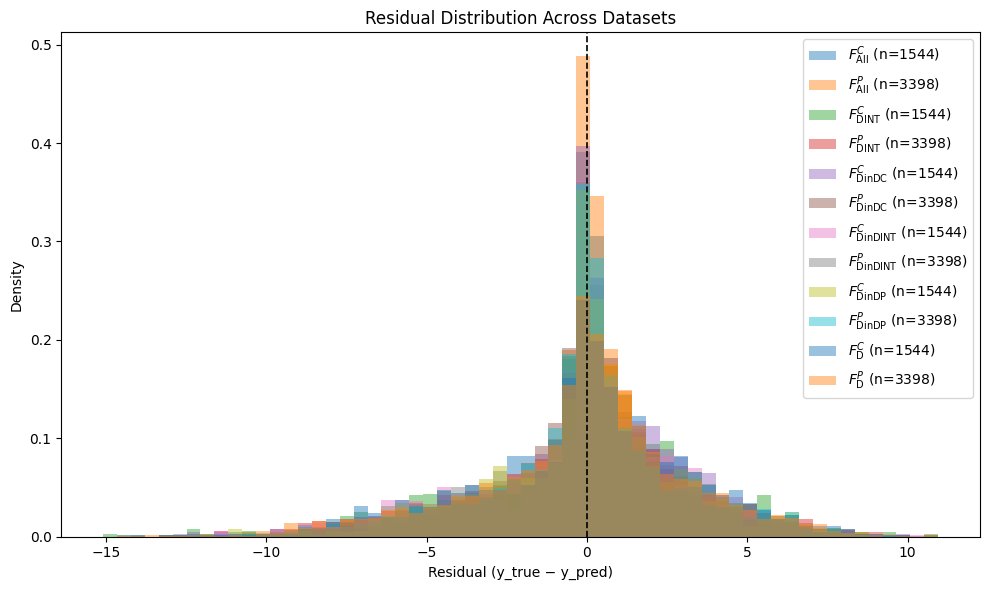

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# =========================================================
# CONFIG – SET FULL PATHS HERE
# =========================================================
CSV_PATH = "XGB_Regressor_Predictions.csv"
OUTPUT_PATH = "residual_distribution.png"

BINS = 60
USE_DENSITY = True   # False → counts, True → density

# =========================================================
# LOAD DATA
# =========================================================
df = pd.read_csv(CSV_PATH)

required_cols = {"Dataset", "y_true", "y_pred"}
missing = required_cols - set(df.columns)
if missing:
    raise ValueError(f"Missing required columns: {missing}")

df = df[["Dataset", "y_true", "y_pred"]].copy()
df["y_true"] = pd.to_numeric(df["y_true"], errors="coerce")
df["y_pred"] = pd.to_numeric(df["y_pred"], errors="coerce")
df.dropna(inplace=True)

# =========================================================
# COMPUTE RESIDUALS
# =========================================================
df["residual"] = df["y_true"] - df["y_pred"]

datasets = sorted(df["Dataset"].astype(str).unique())
if len(datasets) == 0:
    raise ValueError("No valid datasets found.")

# Global bin range (important for fair comparison)
all_res = df["residual"].values
r_min, r_max = all_res.min(), all_res.max()
bins = np.linspace(r_min, r_max, BINS + 1)

# =========================================================
# PLOT
# =========================================================
plt.figure(figsize=(10, 6))

for ds in datasets:
    vals = df.loc[df["Dataset"] == ds, "residual"]
    plt.hist(
        vals,
        bins=bins,
        alpha=0.45,
        density=USE_DENSITY,
        label=f"{ds} (n={len(vals)})",
        histtype="stepfilled"
    )

plt.axvline(0, color="black", linestyle="--", linewidth=1.2)

plt.xlabel("Residual (y_true − y_pred)")
plt.ylabel("Density" if USE_DENSITY else "Count")
plt.title("Residual Distribution Across Datasets")
plt.legend()
plt.tight_layout()

# # =========================================================
# # SAVE
# # =========================================================
# os.makedirs(os.path.dirname(OUTPUT_PATH), exist_ok=True)
# plt.savefig(OUTPUT_PATH, dpi=300)
# plt.close()

print(f"✔ Residual histogram saved to:\n{OUTPUT_PATH}")


<>:16: SyntaxWarning: invalid escape sequence '\m'
<>:17: SyntaxWarning: invalid escape sequence '\m'
<>:18: SyntaxWarning: invalid escape sequence '\m'
<>:19: SyntaxWarning: invalid escape sequence '\m'
<>:16: SyntaxWarning: invalid escape sequence '\m'
<>:17: SyntaxWarning: invalid escape sequence '\m'
<>:18: SyntaxWarning: invalid escape sequence '\m'
<>:19: SyntaxWarning: invalid escape sequence '\m'
C:\Users\andrew\AppData\Local\Temp\1\ipykernel_9048\371365207.py:16: SyntaxWarning: invalid escape sequence '\m'
  "$F_{\mathrm{D}}^{P}$",
C:\Users\andrew\AppData\Local\Temp\1\ipykernel_9048\371365207.py:17: SyntaxWarning: invalid escape sequence '\m'
  "$F_{\mathrm{All}}^{P}$",
C:\Users\andrew\AppData\Local\Temp\1\ipykernel_9048\371365207.py:18: SyntaxWarning: invalid escape sequence '\m'
  "$F_{\mathrm{D}}^{C}$",
C:\Users\andrew\AppData\Local\Temp\1\ipykernel_9048\371365207.py:19: SyntaxWarning: invalid escape sequence '\m'
  "$F_{\mathrm{All}}^{C}$"


✔ Saved residual plot with fixed x-limits (-7, 7)


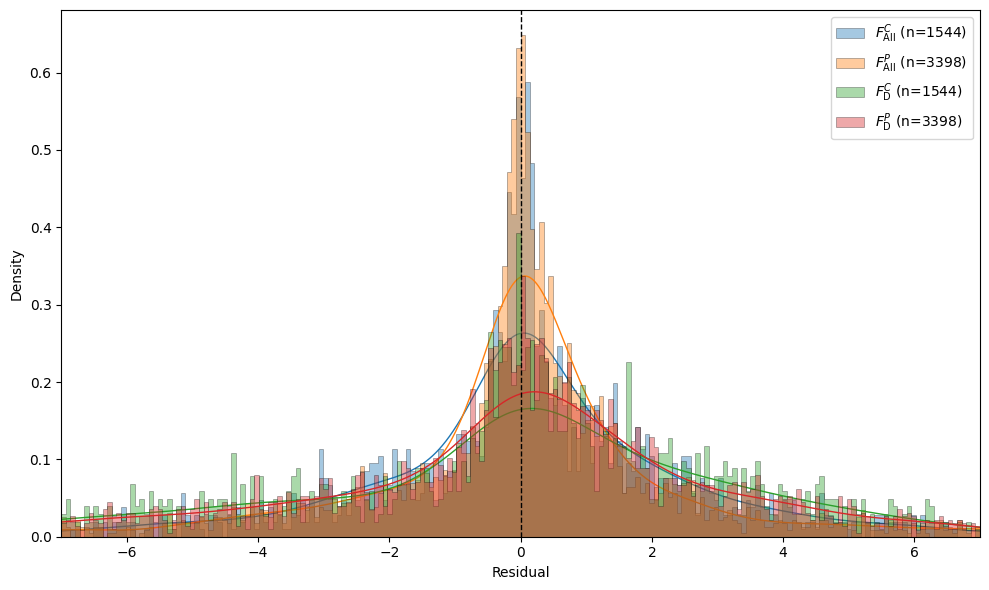

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# =========================================================
# CONFIG
# =========================================================
CSV_PATH = "XGB_Regressor_Predictions.csv"
OUTPUT_PATH = "residual_distribution.png"


# 🔹 Select datasets to plot (set to None or [] to plot all)
SELECTED_DATASETS = [
    "$F_{\mathrm{D}}^{P}$",
    "$F_{\mathrm{All}}^{P}$",
    "$F_{\mathrm{D}}^{C}$",
    "$F_{\mathrm{All}}^{C}$"
]


BINS = 200
USE_DENSITY = True
KDE_POINTS = 2000

X_LIM = (-7, 7)  # ✅ FIXED X-AXIS LIMITS

# =========================================================
# LOAD DATA
# =========================================================
df = pd.read_csv(CSV_PATH)

df = df[["Dataset", "y_true", "y_pred"]].copy()
df["y_true"] = pd.to_numeric(df["y_true"], errors="coerce")
df["y_pred"] = pd.to_numeric(df["y_pred"], errors="coerce")
df.dropna(inplace=True)

if SELECTED_DATASETS:
    df = df[df["Dataset"].isin(SELECTED_DATASETS)]
    if df.empty:
        raise ValueError("No matching datasets found.")

# =========================================================
# COMPUTE RESIDUALS
# =========================================================
df["residual"] = df["y_true"] - df["y_pred"]
datasets = sorted(df["Dataset"].unique())

# Fixed bins for fair comparison
bins = np.linspace(X_LIM[0], X_LIM[1], BINS + 1)
x_grid = np.linspace(X_LIM[0], X_LIM[1], KDE_POINTS)

# =========================================================
# PLOT
# =========================================================
plt.figure(figsize=(10, 6))

color_cycle = plt.rcParams["axes.prop_cycle"].by_key()["color"]

for i, ds in enumerate(datasets):
    r = df.loc[df["Dataset"] == ds, "residual"].values

    color = color_cycle[i % len(color_cycle)]  # 🔹 SAME color for hist + KDE

    # Histogram
    plt.hist(
        r,
        bins=bins,
        density=True,
        alpha=0.4,
        histtype="stepfilled",
        edgecolor="black",
        linewidth=0.5,
        color=color,
        label=f"{ds} (n={len(r)})",
        zorder=1
    )

    # KDE contour (same color)
    kde = gaussian_kde(r)
    plt.plot(
        x_grid,
        kde(x_grid),
        color=color,
        linewidth=1.0,
        zorder=1
    )

# Reference line
plt.axvline(0, color="black", linestyle="--", linewidth=1.0)

# ✅ FIXED AXIS LIMIT
plt.xlim(X_LIM)

plt.xlabel("Residual")
plt.ylabel("Density")
# plt.title("Residual Distribution with KDE Contours")
plt.legend()
plt.tight_layout()

# # =========================================================
# # SAVE
# # =========================================================
# os.makedirs(os.path.dirname(OUTPUT_PATH), exist_ok=True)
# plt.savefig(OUTPUT_PATH, dpi=300)
# plt.close()

print(f"✔ Saved residual plot with fixed x-limits {X_LIM}")


In [4]:


# # =========================================================
# # CONFIG
# # =========================================================

# # Folder containing CSV files
# CSV_FOLDER = r"O:\MyThesis\DataSets\Michal\WorkingSets\LOOCV_CONVR"

# # Output directory (use local disk to avoid permission issues)
# OUTPUT_DIR = r"tsne_outputs"

# # Label column (set None to auto-detect)
# LABEL_COL = "AqScore"   # e.g. "AqScore", "Label", None

# # Feature selection:
# # - None  -> use ALL numeric features (except label)
# # - list -> use ONLY these columns
# # SELECTED_FEATURES = None
# SELECTED_FEATURES = [
#     "spectral_centroid","spectral_bandwidth","spectral_rolloff","zcr","rms","mfcc_1","mfcc_2","mfcc_3",
#     'mfcc_4","mfcc_5","mfcc_6","mfcc_7","mfcc_8","mfcc_9","mfcc_10","mfcc_11","mfcc_12',"mfcc_13","mfcc_14",
#     "mfcc_15","mfcc_16","mfcc_17","mfcc_18","mfcc_19","mfcc_20","pitch_level","pitch_std","intensity_std",
#     "duration","tonal_centroid","mel_spec","log_mel_spec","chroma","speaker","segment_index","segment_begin_sec",
#     "segment_end_sec","mother_to_child","child_to_mother","mother_pitch","child_pitch",
#     "SENSIT_pred","INTRUS_pred","LIMITS_pred","INVOLVE_pred","WITHDRAW_pred","COMPLY_pred","SYNCH_pred","DYADNEG_pred"
# ]

import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

# =========================================================
# CONFIG
# =========================================================

# Folder containing CSV files
CSV_FOLDER = r"O:\MyThesis\DataSets\Michal\WorkingSets\LOOCV2"

# Output directory (use local disk to avoid permission issues)
OUTPUT_DIR = r"tsne_outputs"

# Label column (set None to auto-detect)
LABEL_COL = "AqScore"   # e.g. "AqScore", "Label", None

# Feature selection:
# None  → use ALL numeric columns (except label)
# list  → use ONLY these columns
# SELECTED_FEATURES = None
SELECTED_FEATURES = [
    "spectral_centroid","spectral_bandwidth","spectral_rolloff","zcr","rms","mfcc_1","mfcc_2","mfcc_3",
    "mfcc_4","mfcc_5","mfcc_6","mfcc_7","mfcc_8","mfcc_9","mfcc_10","mfcc_11","mfcc_12","mfcc_13","mfcc_14",
    "mfcc_15","mfcc_16","mfcc_17","mfcc_18","mfcc_19","mfcc_20","pitch_level","pitch_std","intensity_std",
    "duration","tonal_centroid","mel_spec","log_mel_spec","chroma","segment_index","segment_begin_sec",
    "segment_end_sec","mother_to_child","child_to_mother","mother_pitch","child_pitch",
    "SENSIT_pred","INTRUS_pred","LIMITS_pred","INVOLVE_pred","WITHDRAW_pred","COMPLY_pred","SYNCH_pred","DYADNEG_pred"
]

# t-SNE parameters
PERPLEXITY = 30
N_ITER = 1500
RANDOM_SEED = 42
SCALE_FEATURES = True


# =========================================================
# HELPERS
# =========================================================

def safe_mkdir(path):
    os.makedirs(path, exist_ok=True)

def auto_label_col(df):
    for c in ["label", "Label", "y", "Y", "target", "Target", "class", "Class"]:
        if c in df.columns:
            return c
    return df.columns[-1]

def validate_folders(csv_folder, output_dir):
    if not os.path.isdir(csv_folder):
        raise NotADirectoryError(f"CSV_FOLDER not found: {csv_folder}")

    safe_mkdir(output_dir)

    # write permission test
    test_file = os.path.join(output_dir, "__test__.txt")
    with open(test_file, "w") as f:
        f.write("ok")
    os.remove(test_file)

def load_csv_folder(csv_folder):
    csv_files = sorted(glob.glob(os.path.join(csv_folder, "*.csv")))
    if not csv_files:
        raise FileNotFoundError(f"No CSV files found in {csv_folder}")

    dfs = []
    for f in csv_files:
        df = pd.read_csv(f)
        df["__source_file__"] = os.path.basename(f)
        dfs.append(df)

    return pd.concat(dfs, ignore_index=True)

def select_features(df, label_col, selected_features):
    if selected_features is None:
        X = df.drop(columns=[label_col], errors="ignore") \
              .select_dtypes(include=[np.number])
        if X.shape[1] == 0:
            raise ValueError("No numeric feature columns found.")
        return X

    missing = [c for c in selected_features if c not in df.columns]
    if missing:
        raise ValueError(f"Missing selected features: {missing}")

    X = df[selected_features]
    non_numeric = [c for c in X.columns if not pd.api.types.is_numeric_dtype(X[c])]
    if non_numeric:
        raise ValueError(f"Non-numeric selected features: {non_numeric}")

    return X

def plot_tsne_2d(Z, y, out_path):
    y_cat = y.astype("category")
    codes = y_cat.cat.codes

    fig, ax = plt.subplots(figsize=(8, 6))
    sc = ax.scatter(Z[:, 0], Z[:, 1], c=codes, s=15, alpha=0.8)

    handles, _ = sc.legend_elements()
    ax.legend(handles, y_cat.cat.categories, title="Label")

    ax.set_title("t-SNE (2D)")
    ax.set_xlabel("t-SNE 1")
    ax.set_ylabel("t-SNE 2")
    ax.grid(alpha=0.3)

    fig.tight_layout()
    fig.savefig(out_path, dpi=300)
    plt.close(fig)

def plot_tsne_3d(Z, y, out_path):
    y_cat = y.astype("category")
    codes = y_cat.cat.codes

    fig = plt.figure(figsize=(9, 7))
    ax = fig.add_subplot(111, projection="3d")
    sc = ax.scatter(Z[:, 0], Z[:, 1], Z[:, 2], c=codes, s=15, alpha=0.8)

    handles, _ = sc.legend_elements()
    ax.legend(handles, y_cat.cat.categories, title="Label")

    ax.set_title("t-SNE (3D)")
    ax.set_xlabel("t-SNE 1")
    ax.set_ylabel("t-SNE 2")
    ax.set_zlabel("t-SNE 3")

    fig.tight_layout()
    fig.savefig(out_path, dpi=300)
    plt.close(fig)


# =========================================================
# MAIN
# =========================================================

validate_folders(CSV_FOLDER, OUTPUT_DIR)

df = load_csv_folder(CSV_FOLDER)


# Label column
if LABEL_COL is None or LABEL_COL not in df.columns:
    label_col = auto_label_col(df)
else:
    label_col = LABEL_COL

y = df[label_col]

# Features
X_df = select_features(df, label_col, SELECTED_FEATURES)

# Drop NaNs together
combined = pd.concat([X_df, y], axis=1).dropna()
X_df = combined[X_df.columns]
y = combined[label_col].reset_index(drop=True)

X = X_df.to_numpy(dtype=np.float64)

if SCALE_FEATURES:
    X = StandardScaler().fit_transform(X)

n_samples = X.shape[0]
if PERPLEXITY >= n_samples:
    PERPLEXITY = max(2, n_samples // 3)
    print(f"[Info] Adjusted perplexity to {PERPLEXITY}")

# ---- t-SNE 2D
Z2 = TSNE(
    n_components=2,
    perplexity=PERPLEXITY,
    n_iter=N_ITER,
    init="pca",
    random_state=RANDOM_SEED,
    learning_rate="auto",
).fit_transform(X)

out2 = os.path.join(OUTPUT_DIR, "tsne_2d.png")
plot_tsne_2d(Z2, y, out2)

# ---- t-SNE 3D
Z3 = TSNE(
    n_components=3,
    perplexity=PERPLEXITY,
    n_iter=N_ITER,
    init="pca",
    random_state=RANDOM_SEED,
    learning_rate="auto",
).fit_transform(X)

out3 = os.path.join(OUTPUT_DIR, "tsne_3d.png")
plot_tsne_3d(Z3, y, out3)

# ---- Save coordinates
pd.DataFrame({
    "tsne1": Z2[:, 0],
    "tsne2": Z2[:, 1],
    "label": y
}).to_csv(os.path.join(OUTPUT_DIR, "tsne_2d_coords.csv"), index=False)

pd.DataFrame({
    "tsne1": Z3[:, 0],
    "tsne2": Z3[:, 1],
    "tsne3": Z3[:, 2],
    "label": y
}).to_csv(os.path.join(OUTPUT_DIR, "tsne_3d_coords.csv"), index=False)

print("✅ t-SNE completed successfully")
print("CSV files loaded:", df["__source_file__"].nunique())
print("Samples used:", X.shape[0])
print("Features used:", list(X_df.columns))
print("Saved to:", OUTPUT_DIR)

o:\MyThesis\Project\Code\.venv\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
o:\MyThesis\Project\Code\.venv\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


✅ t-SNE completed successfully
CSV files loaded: 58
Samples used: 4942
Features used: ['spectral_centroid', 'spectral_bandwidth', 'spectral_rolloff', 'zcr', 'rms', 'mfcc_1', 'mfcc_2', 'mfcc_3', 'mfcc_4', 'mfcc_5', 'mfcc_6', 'mfcc_7', 'mfcc_8', 'mfcc_9', 'mfcc_10', 'mfcc_11', 'mfcc_12', 'mfcc_13', 'mfcc_14', 'mfcc_15', 'mfcc_16', 'mfcc_17', 'mfcc_18', 'mfcc_19', 'mfcc_20', 'pitch_level', 'pitch_std', 'intensity_std', 'duration', 'tonal_centroid', 'mel_spec', 'log_mel_spec', 'chroma', 'segment_index', 'segment_begin_sec', 'segment_end_sec', 'mother_to_child', 'child_to_mother', 'mother_pitch', 'child_pitch', 'SENSIT_pred', 'INTRUS_pred', 'LIMITS_pred', 'INVOLVE_pred', 'WITHDRAW_pred', 'COMPLY_pred', 'SYNCH_pred', 'DYADNEG_pred']
Saved to: tsne_outputs


In [6]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

# =========================================================
# CONFIG
# =========================================================
CSV_FOLDER = r"O:\MyThesis\DataSets\Michal\WorkingSets\LOOCV_CONVR"  # folder with many .csv files
OUTPUT_DIR = r"tsne_outputs"  # local output to avoid O:\ permission issues

SPEAKER_COL = "speaker"          # column used to split
MOTHER_VALUE = "mother"          # expected values: "mother"
CHILD_VALUE = "child"            # expected values: "child"

LABEL_COL = "AqScore"              # label column for coloring (set None to auto-detect / last column)
# SELECTED_FEATURES = None         # None -> all numeric features; or list of feature names
SELECTED_FEATURES = [
    "spectral_centroid","spectral_bandwidth","spectral_rolloff","zcr","rms","mfcc_1","mfcc_2","mfcc_3",
    "mfcc_4","mfcc_5","mfcc_6","mfcc_7","mfcc_8","mfcc_9","mfcc_10","mfcc_11","mfcc_12","mfcc_13","mfcc_14",
    "mfcc_15","mfcc_16","mfcc_17","mfcc_18","mfcc_19","mfcc_20","pitch_level","pitch_std","intensity_std",
    "duration","tonal_centroid","mel_spec","log_mel_spec","chroma","segment_index","segment_begin_sec",
    "segment_end_sec","mother_to_child","child_to_mother","mother_pitch","child_pitch",
    "SENSIT_pred","INTRUS_pred","LIMITS_pred","INVOLVE_pred","WITHDRAW_pred","COMPLY_pred","SYNCH_pred","DYADNEG_pred"
]

# t-SNE params
PERPLEXITY = 30
N_ITER = 1500
RANDOM_SEED = 42
SCALE_FEATURES = True


# =========================================================
# HELPERS
# =========================================================
def safe_mkdir(path: str) -> None:
    os.makedirs(path, exist_ok=True)

def validate_folders(csv_folder: str, output_dir: str) -> None:
    if not os.path.isdir(csv_folder):
        raise NotADirectoryError(f"CSV_FOLDER not found: {csv_folder}")
    safe_mkdir(output_dir)

    # write permission test
    test_file = os.path.join(output_dir, "__write_test__.txt")
    try:
        with open(test_file, "w", encoding="utf-8") as f:
            f.write("ok")
        os.remove(test_file)
    except Exception as e:
        raise PermissionError(
            f"Cannot write to OUTPUT_DIR: {output_dir}\n"
            f"Choose a different folder (e.g., C:\\Temp\\tsne_outputs). Error: {e}"
        )

def load_csv_folder(csv_folder: str) -> pd.DataFrame:
    csv_files = sorted(glob.glob(os.path.join(csv_folder, "*.csv")))
    if not csv_files:
        raise FileNotFoundError(f"No CSV files found in: {csv_folder}")

    dfs = []
    for fpath in csv_files:
        d = pd.read_csv(fpath)
        d["__source_file__"] = os.path.basename(fpath)
        dfs.append(d)

    return pd.concat(dfs, ignore_index=True)

def auto_label_col(df: pd.DataFrame) -> str:
    for c in ["label", "Label", "y", "Y", "target", "Target", "class", "Class"]:
        if c in df.columns:
            return c
    return df.columns[-1]

def split_by_speaker(df: pd.DataFrame, speaker_col: str, mother_value: str, child_value: str):
    if speaker_col not in df.columns:
        raise ValueError(f"Speaker column '{speaker_col}' not found in dataframe columns.")

    sp = df[speaker_col].astype(str).str.strip().str.lower()
    mother_df = df[sp == mother_value.lower()].copy()
    child_df = df[sp == child_value.lower()].copy()

    return mother_df, child_df

def select_features(df: pd.DataFrame, label_col: str, selected_features):
    if selected_features is None:
        X = df.drop(columns=[label_col], errors="ignore").select_dtypes(include=[np.number]).copy()
        if X.shape[1] == 0:
            raise ValueError("No numeric feature columns found.")
        return X

    missing = [c for c in selected_features if c not in df.columns]
    if missing:
        raise ValueError(f"Missing selected features: {missing}")

    X = df[selected_features].copy()
    non_numeric = [c for c in X.columns if not pd.api.types.is_numeric_dtype(X[c])]
    if non_numeric:
        raise ValueError(f"Non-numeric selected features: {non_numeric}")
    return X

def prep_xy(df: pd.DataFrame, label_col: str, selected_features):
    if label_col is None or label_col not in df.columns:
        label_col = auto_label_col(df)

    y = df[label_col]
    X_df = select_features(df, label_col, selected_features)

    # Drop NaNs together
    combined = pd.concat([X_df, y], axis=1).dropna()
    X_df = combined[X_df.columns]
    y = combined[label_col].reset_index(drop=True)

    X = X_df.to_numpy(dtype=np.float64)
    if SCALE_FEATURES:
        X = StandardScaler().fit_transform(X)

    return X, y, label_col, list(X_df.columns)

def tsne_fit(X: np.ndarray, n_components: int, perplexity: int):
    # Perplexity must be < n_samples
    n = X.shape[0]
    if perplexity >= n:
        perplexity = max(2, min(30, n - 1))
        print(f"[Info] Adjusted perplexity to {perplexity} (n_samples={n})")

    return TSNE(
        n_components=n_components,
        perplexity=perplexity,
        n_iter=N_ITER,
        init="pca",
        random_state=RANDOM_SEED,
        learning_rate="auto",
    ).fit_transform(X)

def plot_tsne_2d(Z: np.ndarray, y: pd.Series, out_path: str, title: str):
    y_cat = pd.Series(y).astype("category")
    codes = y_cat.cat.codes.to_numpy()
    labels = list(y_cat.cat.categories.astype(str))

    fig, ax = plt.subplots(figsize=(8, 6))
    sc = ax.scatter(Z[:, 0], Z[:, 1], c=codes, s=15, alpha=0.85)

    handles, _ = sc.legend_elements()
    ax.legend(handles, labels, title="Label", loc="best", frameon=True)

    ax.set_title(title)
    ax.set_xlabel("t-SNE 1")
    ax.set_ylabel("t-SNE 2")
    ax.grid(True, linewidth=0.3, alpha=0.4)

    fig.tight_layout()
    fig.savefig(out_path, dpi=300)
    plt.close(fig)

def plot_tsne_3d(Z: np.ndarray, y: pd.Series, out_path: str, title: str):
    y_cat = pd.Series(y).astype("category")
    codes = y_cat.cat.codes.to_numpy()
    labels = list(y_cat.cat.categories.astype(str))

    fig = plt.figure(figsize=(9, 7))
    ax = fig.add_subplot(111, projection="3d")
    sc = ax.scatter(Z[:, 0], Z[:, 1], Z[:, 2], c=codes, s=15, alpha=0.85)

    handles, _ = sc.legend_elements()
    ax.legend(handles, labels, title="Label", loc="best", frameon=True)

    ax.set_title(title)
    ax.set_xlabel("t-SNE 1")
    ax.set_ylabel("t-SNE 2")
    ax.set_zlabel("t-SNE 3")

    fig.tight_layout()
    fig.savefig(out_path, dpi=300)
    plt.close(fig)

def save_coords(Z2, Z3, y, out_prefix):
    pd.DataFrame({"tsne1": Z2[:, 0], "tsne2": Z2[:, 1], "label": y.astype(str)}).to_csv(
        out_prefix + "_tsne2d_coords.csv", index=False
    )
    pd.DataFrame({"tsne1": Z3[:, 0], "tsne2": Z3[:, 1], "tsne3": Z3[:, 2], "label": y.astype(str)}).to_csv(
        out_prefix + "_tsne3d_coords.csv", index=False
    )


# =========================================================
# MAIN
# =========================================================
validate_folders(CSV_FOLDER, OUTPUT_DIR)

# Load and combine CSVs
df = load_csv_folder(CSV_FOLDER)

# Split by speaker
mother_df, child_df = split_by_speaker(df, SPEAKER_COL, MOTHER_VALUE, CHILD_VALUE)

print("Total rows:", len(df))
print("Mother rows:", len(mother_df))
print("Child rows:", len(child_df))
print("\nSpeaker counts (raw):")
print(df[SPEAKER_COL].value_counts(dropna=False))

# Prepare Mother X/y
if len(mother_df) > 0:
    Xm, ym, used_label_col_m, used_feats_m = prep_xy(mother_df, LABEL_COL, SELECTED_FEATURES)

    Z2m = tsne_fit(Xm, n_components=2, perplexity=PERPLEXITY)
    Z3m = tsne_fit(Xm, n_components=3, perplexity=PERPLEXITY)

    out2 = os.path.join(OUTPUT_DIR, "mother_tsne_2d.png")
    out3 = os.path.join(OUTPUT_DIR, "mother_tsne_3d.png")

    plot_tsne_2d(Z2m, ym, out2, title="Mother t-SNE (2D)")
    plot_tsne_3d(Z3m, ym, out3, title="Mother t-SNE (3D)")

    save_coords(Z2m, Z3m, ym, os.path.join(OUTPUT_DIR, "mother"))
    print("\nMother label column:", used_label_col_m)
    print("Mother features used:", used_feats_m)
    print("Saved Mother plots:", out2, out3)

else:
    print("\n[Warning] No mother rows found. Check speaker values.")

# Prepare Child X/y
if len(child_df) > 0:
    Xc, yc, used_label_col_c, used_feats_c = prep_xy(child_df, LABEL_COL, SELECTED_FEATURES)

    Z2c = tsne_fit(Xc, n_components=2, perplexity=PERPLEXITY)
    Z3c = tsne_fit(Xc, n_components=3, perplexity=PERPLEXITY)

    out2 = os.path.join(OUTPUT_DIR, "child_tsne_2d.png")
    out3 = os.path.join(OUTPUT_DIR, "child_tsne_3d.png")

    plot_tsne_2d(Z2c, yc, out2, title="Child t-SNE (2D)")
    plot_tsne_3d(Z3c, yc, out3, title="Child t-SNE (3D)")

    save_coords(Z2c, Z3c, yc, os.path.join(OUTPUT_DIR, "child"))
    print("\nChild label column:", used_label_col_c)
    print("Child features used:", used_feats_c)
    print("Saved Child plots:", out2, out3)

else:
    print("\n[Warning] No child rows found. Check speaker values.")

print("\n✅ Done. Output folder:", OUTPUT_DIR)

Total rows: 5427
Mother rows: 3725
Child rows: 1702

Speaker counts (raw):
speaker
Mother    3725
Child     1702
Name: count, dtype: int64


o:\MyThesis\Project\Code\.venv\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
o:\MyThesis\Project\Code\.venv\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(



Mother label column: AqScore
Mother features used: ['spectral_centroid', 'spectral_bandwidth', 'spectral_rolloff', 'zcr', 'rms', 'mfcc_1', 'mfcc_2', 'mfcc_3', 'mfcc_4', 'mfcc_5', 'mfcc_6', 'mfcc_7', 'mfcc_8', 'mfcc_9', 'mfcc_10', 'mfcc_11', 'mfcc_12', 'mfcc_13', 'mfcc_14', 'mfcc_15', 'mfcc_16', 'mfcc_17', 'mfcc_18', 'mfcc_19', 'mfcc_20', 'pitch_level', 'pitch_std', 'intensity_std', 'duration', 'tonal_centroid', 'mel_spec', 'log_mel_spec', 'chroma', 'segment_index', 'segment_begin_sec', 'segment_end_sec', 'mother_to_child', 'child_to_mother', 'mother_pitch', 'child_pitch', 'SENSIT_pred', 'INTRUS_pred', 'LIMITS_pred', 'INVOLVE_pred', 'WITHDRAW_pred', 'COMPLY_pred', 'SYNCH_pred', 'DYADNEG_pred']
Saved Mother plots: tsne_outputs\mother_tsne_2d.png tsne_outputs\mother_tsne_3d.png


o:\MyThesis\Project\Code\.venv\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
o:\MyThesis\Project\Code\.venv\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(



Child label column: AqScore
Child features used: ['spectral_centroid', 'spectral_bandwidth', 'spectral_rolloff', 'zcr', 'rms', 'mfcc_1', 'mfcc_2', 'mfcc_3', 'mfcc_4', 'mfcc_5', 'mfcc_6', 'mfcc_7', 'mfcc_8', 'mfcc_9', 'mfcc_10', 'mfcc_11', 'mfcc_12', 'mfcc_13', 'mfcc_14', 'mfcc_15', 'mfcc_16', 'mfcc_17', 'mfcc_18', 'mfcc_19', 'mfcc_20', 'pitch_level', 'pitch_std', 'intensity_std', 'duration', 'tonal_centroid', 'mel_spec', 'log_mel_spec', 'chroma', 'segment_index', 'segment_begin_sec', 'segment_end_sec', 'mother_to_child', 'child_to_mother', 'mother_pitch', 'child_pitch', 'SENSIT_pred', 'INTRUS_pred', 'LIMITS_pred', 'INVOLVE_pred', 'WITHDRAW_pred', 'COMPLY_pred', 'SYNCH_pred', 'DYADNEG_pred']
Saved Child plots: tsne_outputs\child_tsne_2d.png tsne_outputs\child_tsne_3d.png

✅ Done. Output folder: tsne_outputs


In [11]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

# =========================================================
# CONFIG
# =========================================================
CSV_FOLDER = r"O:\MyThesis\DataSets\Michal\WorkingSets\LOOCV2"
OUTPUT_DIR = r"tsne_outputs"

SPEAKER_COL = "speaker"
MOTHER_VALUE = "mother"
CHILD_VALUE = "child"

# Continuous score column (for colorbar). Example: "AqScore"
SCORE_COL = "AqScore"   # <-- change to your continuous score column name

# Feature selection: None -> all numeric (except speaker + score); or list of feature names
# SELECTED_FEATURES = None
SELECTED_FEATURES = [
    "spectral_centroid","spectral_bandwidth","spectral_rolloff","zcr","rms",
    "mfcc_1","mfcc_2","mfcc_3","mfcc_4","mfcc_5","mfcc_6","mfcc_7","mfcc_8","mfcc_9","mfcc_10","mfcc_11", #FD
    "mfcc_12","mfcc_13","mfcc_14","mfcc_15","mfcc_16","mfcc_17","mfcc_18","mfcc_19","mfcc_20", #FD
    "pitch_level","pitch_std","intensity_std","duration","tonal_centroid","mel_spec","log_mel_spec","chroma", # FD
    "segment_begin_sec","segment_end_sec","mother_to_child","child_to_mother","mother_pitch","child_pitch", # FDINT
    # "SENSIT_pred","INTRUS_pred","LIMITS_pred", #FDinDP
    # "INVOLVE_pred","WITHDRAW_pred","COMPLY_pred",#FDinDC
    "SYNCH_pred","DYADNEG_pred" #FDinDINT
]

# t-SNE params
PERPLEXITY = 30
N_ITER = 1500
RANDOM_SEED = 42
SCALE_FEATURES = True
PREF = "FDinDINT_"

# =========================================================
# HELPERS
# =========================================================
def safe_mkdir(path: str) -> None:
    os.makedirs(path, exist_ok=True)

def validate_folders(csv_folder: str, output_dir: str) -> None:
    if not os.path.isdir(csv_folder):
        raise NotADirectoryError(f"CSV_FOLDER not found: {csv_folder}")
    safe_mkdir(output_dir)
    test_file = os.path.join(output_dir, "__write_test__.txt")
    with open(test_file, "w", encoding="utf-8") as f:
        f.write("ok")
    os.remove(test_file)

def load_csv_folder(csv_folder: str) -> pd.DataFrame:
    files = sorted(glob.glob(os.path.join(csv_folder, "*.csv")))
    if not files:
        raise FileNotFoundError(f"No CSV files found in: {csv_folder}")
    dfs = []
    for fp in files:
        d = pd.read_csv(fp)
        d["__source_file__"] = os.path.basename(fp)
        dfs.append(d)
    return pd.concat(dfs, ignore_index=True)

def split_by_speaker(df: pd.DataFrame, speaker_col: str, mother_value: str, child_value: str):
    if speaker_col not in df.columns:
        raise ValueError(f"Speaker column '{speaker_col}' not found.")
    sp = df[speaker_col].astype(str).str.strip().str.lower()
    mother_df = df[sp == mother_value.lower()].copy()
    child_df = df[sp == child_value.lower()].copy()
    return mother_df, child_df

def select_features(df: pd.DataFrame, selected_features, exclude_cols: list[str]):
    if selected_features is None:
        X = df.drop(columns=[c for c in exclude_cols if c in df.columns], errors="ignore") \
              .select_dtypes(include=[np.number]).copy()
        if X.shape[1] == 0:
            raise ValueError("No numeric feature columns found after exclusions.")
        return X

    missing = [c for c in selected_features if c not in df.columns]
    if missing:
        raise ValueError(f"Missing selected features: {missing}")
    X = df[selected_features].copy()

    non_numeric = [c for c in X.columns if not pd.api.types.is_numeric_dtype(X[c])]
    if non_numeric:
        raise ValueError(f"Selected feature columns must be numeric. Non-numeric: {non_numeric}")
    return X

def prep_X_score(df: pd.DataFrame, score_col: str, selected_features):
    if score_col not in df.columns:
        raise ValueError(f"SCORE_COL '{score_col}' not found in dataframe columns.")

    score = pd.to_numeric(df[score_col], errors="coerce")

    # Exclude non-feature columns from automatic selection
    exclude_cols = [SPEAKER_COL, score_col, "__source_file__"]
    X_df = select_features(df, selected_features, exclude_cols)

    # Drop NaNs together (features + score)
    combined = pd.concat([X_df, score.rename("score")], axis=1).dropna()
    X_df = combined[X_df.columns]
    score = combined["score"].reset_index(drop=True)

    X = X_df.to_numpy(dtype=np.float64)
    if SCALE_FEATURES:
        X = StandardScaler().fit_transform(X)

    return X, score, list(X_df.columns)

def tsne_fit(X: np.ndarray, n_components: int, perplexity: int):
    n = X.shape[0]
    if n < 5:
        raise ValueError(f"Not enough samples for t-SNE: {n}")

    if perplexity >= n:
        perplexity = max(2, min(30, n - 1))
        print(f"[Info] Adjusted perplexity to {perplexity} (n_samples={n})")

    return TSNE(
        n_components=n_components,
        perplexity=perplexity,
        n_iter=N_ITER,
        init="pca",
        random_state=RANDOM_SEED,
        learning_rate="auto",
    ).fit_transform(X)

def plot_tsne_2d_continuous(Z: np.ndarray, score: pd.Series, out_path: str, title: str):
    fig, ax = plt.subplots(figsize=(8, 6))

    sc = ax.scatter(
        Z[:, 0], Z[:, 1],
        c=score.to_numpy(),
        s=15,
        alpha=0.85
    )

    cbar = fig.colorbar(sc, ax=ax)
    cbar.set_label(SCORE_COL)

    ax.set_title(title)
    ax.set_xlabel("t-SNE 1")
    ax.set_ylabel("t-SNE 2")
    ax.grid(True, linewidth=0.3, alpha=0.4)

    fig.tight_layout()
    fig.savefig(out_path, dpi=300)
    plt.close(fig)

def plot_tsne_3d_continuous(Z: np.ndarray, score: pd.Series, out_path: str, title: str):
    fig = plt.figure(figsize=(9, 7))
    ax = fig.add_subplot(111, projection="3d")

    sc = ax.scatter(
        Z[:, 0], Z[:, 1], Z[:, 2],
        c=score.to_numpy(),
        s=15,
        alpha=0.85
    )

    cbar = fig.colorbar(sc, ax=ax, shrink=0.7, pad=0.08)
    cbar.set_label(SCORE_COL)

    ax.set_title(title)
    ax.set_xlabel("t-SNE 1")
    ax.set_ylabel("t-SNE 2")
    ax.set_zlabel("t-SNE 3")

    fig.tight_layout()
    fig.savefig(out_path, dpi=300)
    plt.close(fig)

def save_coords(Z2, Z3, score, out_prefix):
    pd.DataFrame({
        "tsne1": Z2[:, 0],
        "tsne2": Z2[:, 1],
        "score": score
    }).to_csv(out_prefix + "_tsne2d_coords.csv", index=False)

    pd.DataFrame({
        "tsne1": Z3[:, 0],
        "tsne2": Z3[:, 1],
        "tsne3": Z3[:, 2],
        "score": score
    }).to_csv(out_prefix + "_tsne3d_coords.csv", index=False)


# =========================================================
# MAIN
# =========================================================
validate_folders(CSV_FOLDER, OUTPUT_DIR)

df = load_csv_folder(CSV_FOLDER)
mother_df, child_df = split_by_speaker(df, SPEAKER_COL, MOTHER_VALUE, CHILD_VALUE)

print("Total rows:", len(df))
print("Parent rows:", len(mother_df))
print("Child rows:", len(child_df))
print("\nSpeaker counts:")
print(df[SPEAKER_COL].value_counts(dropna=False))

# ------------------ Mother ------------------
if len(mother_df) > 0:
    Xm, sm, feats_m = prep_X_score(mother_df, SCORE_COL, SELECTED_FEATURES)

    Z2m = tsne_fit(Xm, 2, PERPLEXITY)
    Z3m = tsne_fit(Xm, 3, PERPLEXITY)

    out2m = os.path.join(OUTPUT_DIR, f"{PREF}Parent_tsne_2d_continuous.png")
    out3m = os.path.join(OUTPUT_DIR, f"{PREF}Parent_tsne_3d_continuous.png")

    plot_tsne_2d_continuous(Z2m, sm, out2m, f"{PREF}Parent t-SNE (2D) — Continuous Score")
    plot_tsne_3d_continuous(Z3m, sm, out3m, f"{PREF}Parent t-SNE (3D) — Continuous Score")

    save_coords(Z2m, Z3m, sm, os.path.join(OUTPUT_DIR, "mother"))
    print("\nMother features used:", feats_m)
    print("Saved:", out2m, out3m)
else:
    print("\n[Warning] No mother rows found (check speaker values).")

# ------------------ Child -------------------
if len(child_df) > 0:
    Xc, sc_, feats_c = prep_X_score(child_df, SCORE_COL, SELECTED_FEATURES)

    Z2c = tsne_fit(Xc, 2, PERPLEXITY)
    Z3c = tsne_fit(Xc, 3, PERPLEXITY)

    out2c = os.path.join(OUTPUT_DIR, f"{PREF}child_tsne_2d_continuous.png")
    out3c = os.path.join(OUTPUT_DIR, f"{PREF}child_tsne_3d_continuous.png")

    plot_tsne_2d_continuous(Z2c, sc_, out2c, f"{PREF}Child t-SNE (2D) — Continuous Score")
    plot_tsne_3d_continuous(Z3c, sc_, out3c, f"{PREF}Child t-SNE (3D) — Continuous Score")

    save_coords(Z2c, Z3c, sc_, os.path.join(OUTPUT_DIR, "child"))
    print("\nChild features used:", feats_c)
    print("Saved:", out2c, out3c)
else:
    print("\n[Warning] No child rows found (check speaker values).")

print("\n✅ Done. Output folder:", OUTPUT_DIR)

Total rows: 4942
Parent rows: 3398
Child rows: 1544

Speaker counts:
speaker
Mother    3398
Child     1544
Name: count, dtype: int64


o:\MyThesis\Project\Code\.venv\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
o:\MyThesis\Project\Code\.venv\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(



Mother features used: ['spectral_centroid', 'spectral_bandwidth', 'spectral_rolloff', 'zcr', 'rms', 'mfcc_1', 'mfcc_2', 'mfcc_3', 'mfcc_4', 'mfcc_5', 'mfcc_6', 'mfcc_7', 'mfcc_8', 'mfcc_9', 'mfcc_10', 'mfcc_11', 'mfcc_12', 'mfcc_13', 'mfcc_14', 'mfcc_15', 'mfcc_16', 'mfcc_17', 'mfcc_18', 'mfcc_19', 'mfcc_20', 'pitch_level', 'pitch_std', 'intensity_std', 'duration', 'tonal_centroid', 'mel_spec', 'log_mel_spec', 'chroma', 'segment_begin_sec', 'segment_end_sec', 'mother_to_child', 'child_to_mother', 'mother_pitch', 'child_pitch', 'SYNCH_pred', 'DYADNEG_pred']
Saved: tsne_outputs\FDinDINT_Parent_tsne_2d_continuous.png tsne_outputs\FDinDINT_Parent_tsne_3d_continuous.png


o:\MyThesis\Project\Code\.venv\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
o:\MyThesis\Project\Code\.venv\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(



Child features used: ['spectral_centroid', 'spectral_bandwidth', 'spectral_rolloff', 'zcr', 'rms', 'mfcc_1', 'mfcc_2', 'mfcc_3', 'mfcc_4', 'mfcc_5', 'mfcc_6', 'mfcc_7', 'mfcc_8', 'mfcc_9', 'mfcc_10', 'mfcc_11', 'mfcc_12', 'mfcc_13', 'mfcc_14', 'mfcc_15', 'mfcc_16', 'mfcc_17', 'mfcc_18', 'mfcc_19', 'mfcc_20', 'pitch_level', 'pitch_std', 'intensity_std', 'duration', 'tonal_centroid', 'mel_spec', 'log_mel_spec', 'chroma', 'segment_begin_sec', 'segment_end_sec', 'mother_to_child', 'child_to_mother', 'mother_pitch', 'child_pitch', 'SYNCH_pred', 'DYADNEG_pred']
Saved: tsne_outputs\FDinDINT_child_tsne_2d_continuous.png tsne_outputs\FDinDINT_child_tsne_3d_continuous.png

✅ Done. Output folder: tsne_outputs


In [17]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

# =========================================================
# CONFIG
# =========================================================
CSV_FOLDER = r"O:\MyThesis\DataSets\Michal\WorkingSets\LOOCV2"
OUTPUT_DIR = r"pca_outputs"

SPEAKER_COL = "speaker"
MOTHER_VALUE = "mother"
CHILD_VALUE = "child"

# Continuous score column (for colorbar). Example: "AqScore"
SCORE_COL = "AqScore"   # <-- change if needed

# Feature selection: None -> all numeric (except speaker + score); or list of feature names
# SELECTED_FEATURES = None
SELECTED_FEATURES = [
    "spectral_centroid","spectral_bandwidth","spectral_rolloff","zcr","rms",
    "mfcc_1","mfcc_2","mfcc_3","mfcc_4","mfcc_5","mfcc_6","mfcc_7","mfcc_8","mfcc_9","mfcc_10","mfcc_11", #FD
    "mfcc_12","mfcc_13","mfcc_14","mfcc_15","mfcc_16","mfcc_17","mfcc_18","mfcc_19","mfcc_20", #FD
    "pitch_level","pitch_std","intensity_std","duration","tonal_centroid","mel_spec","log_mel_spec","chroma", # FD
    "segment_begin_sec","segment_end_sec","mother_to_child","child_to_mother","mother_pitch","child_pitch", # FDINT
    "SENSIT_pred","INTRUS_pred","LIMITS_pred", #FDinDP
    "INVOLVE_pred","WITHDRAW_pred","COMPLY_pred",#FDinDC
    "SYNCH_pred","DYADNEG_pred" #FDinDINT
]

# PCA params
RANDOM_SEED = 42
SCALE_FEATURES = True
PREF = "FALL_"

# =========================================================
# HELPERS
# =========================================================
def safe_mkdir(path: str) -> None:
    os.makedirs(path, exist_ok=True)

def validate_folders(csv_folder: str, output_dir: str) -> None:
    if not os.path.isdir(csv_folder):
        raise NotADirectoryError(f"CSV_FOLDER not found: {csv_folder}")
    safe_mkdir(output_dir)
    test_file = os.path.join(output_dir, "__write_test__.txt")
    with open(test_file, "w", encoding="utf-8") as f:
        f.write("ok")
    os.remove(test_file)

def load_csv_folder(csv_folder: str) -> pd.DataFrame:
    files = sorted(glob.glob(os.path.join(csv_folder, "*.csv")))
    if not files:
        raise FileNotFoundError(f"No CSV files found in: {csv_folder}")
    dfs = []
    for fp in files:
        d = pd.read_csv(fp)
        d["__source_file__"] = os.path.basename(fp)
        dfs.append(d)
    return pd.concat(dfs, ignore_index=True)

def split_by_speaker(df: pd.DataFrame, speaker_col: str, mother_value: str, child_value: str):
    if speaker_col not in df.columns:
        raise ValueError(f"Speaker column '{speaker_col}' not found.")
    sp = df[speaker_col].astype(str).str.strip().str.lower()
    mother_df = df[sp == mother_value.lower()].copy()
    child_df = df[sp == child_value.lower()].copy()
    return mother_df, child_df

def select_features(df: pd.DataFrame, selected_features, exclude_cols: list[str]):
    if selected_features is None:
        X = (
            df.drop(columns=[c for c in exclude_cols if c in df.columns], errors="ignore")
              .select_dtypes(include=[np.number]).copy()
        )
        if X.shape[1] == 0:
            raise ValueError("No numeric feature columns found after exclusions.")
        return X

    missing = [c for c in selected_features if c not in df.columns]
    if missing:
        raise ValueError(f"Missing selected features: {missing}")

    X = df[selected_features].copy()
    non_numeric = [c for c in X.columns if not pd.api.types.is_numeric_dtype(X[c])]
    if non_numeric:
        raise ValueError(f"Selected feature columns must be numeric. Non-numeric: {non_numeric}")
    return X

def prep_X_score(df: pd.DataFrame, score_col: str, selected_features):
    if score_col not in df.columns:
        raise ValueError(f"SCORE_COL '{score_col}' not found in dataframe columns.")

    score = pd.to_numeric(df[score_col], errors="coerce")

    # Exclude non-feature columns from automatic selection
    exclude_cols = [SPEAKER_COL, score_col, "__source_file__"]
    X_df = select_features(df, selected_features, exclude_cols)

    # Drop NaNs together (features + score)
    combined = pd.concat([X_df, score.rename("score")], axis=1).dropna()
    X_df = combined[X_df.columns]
    score = combined["score"].reset_index(drop=True)

    X = X_df.to_numpy(dtype=np.float64)
    if SCALE_FEATURES:
        X = StandardScaler().fit_transform(X)

    return X, score, list(X_df.columns)

def pca_fit(X: np.ndarray, n_components: int):
    n = X.shape[0]
    if n < 3:
        raise ValueError(f"Not enough samples for PCA: {n}")

    # n_components cannot exceed min(n_samples, n_features)
    max_comp = min(X.shape[0], X.shape[1])
    n_components = min(n_components, max_comp)

    pca = PCA(n_components=n_components, random_state=RANDOM_SEED)
    Z = pca.fit_transform(X)
    return Z, pca

def plot_pca_2d_continuous(Z: np.ndarray, score: pd.Series, pca: PCA, out_path: str, title: str):
    fig, ax = plt.subplots(figsize=(8, 6))

    sc = ax.scatter(
        Z[:, 0], Z[:, 1],
        c=score.to_numpy(),
        s=15,
        alpha=0.85
    )

    cbar = fig.colorbar(sc, ax=ax)
    cbar.set_label(SCORE_COL)

    evr = pca.explained_variance_ratio_
    ax.set_title(title)
    ax.set_xlabel(f"PC1 ({evr[0]*100:.2f}%)")
    ax.set_ylabel(f"PC2 ({evr[1]*100:.2f}%)")
    ax.grid(True, linewidth=0.3, alpha=0.4)

    fig.tight_layout()
    fig.savefig(out_path, dpi=300)
    plt.close(fig)

def plot_pca_3d_continuous(Z: np.ndarray, score: pd.Series, pca: PCA, out_path: str, title: str):
    fig = plt.figure(figsize=(9, 7))
    ax = fig.add_subplot(111, projection="3d")

    sc = ax.scatter(
        Z[:, 0], Z[:, 1], Z[:, 2],
        c=score.to_numpy(),
        s=15,
        alpha=0.85
    )

    cbar = fig.colorbar(sc, ax=ax, shrink=0.7, pad=0.08)
    cbar.set_label(SCORE_COL)

    evr = pca.explained_variance_ratio_
    ax.set_title(title)
    ax.set_xlabel(f"PC1 ({evr[0]*100:.2f}%)")
    ax.set_ylabel(f"PC2 ({evr[1]*100:.2f}%)")
    ax.set_zlabel(f"PC3 ({evr[2]*100:.2f}%)")

    fig.tight_layout()
    fig.savefig(out_path, dpi=300)
    plt.close(fig)

def save_coords_pca(Z2, Z3, score, out_prefix, pca2: PCA, pca3: PCA):
    pd.DataFrame({
        "pc1": Z2[:, 0],
        "pc2": Z2[:, 1],
        "score": score
    }).to_csv(out_prefix + "_pca2d_coords.csv", index=False)

    pd.DataFrame({
        "pc1": Z3[:, 0],
        "pc2": Z3[:, 1],
        "pc3": Z3[:, 2],
        "score": score
    }).to_csv(out_prefix + "_pca3d_coords.csv", index=False)

    # also save explained variance ratios for reference
    pd.DataFrame({
        "component": ["PC1", "PC2"],
        "explained_variance_ratio": pca2.explained_variance_ratio_
    }).to_csv(out_prefix + "_pca2d_explained_variance.csv", index=False)

    pd.DataFrame({
        "component": ["PC1", "PC2", "PC3"],
        "explained_variance_ratio": pca3.explained_variance_ratio_
    }).to_csv(out_prefix + "_pca3d_explained_variance.csv", index=False)

# =========================================================
# MAIN
# =========================================================
validate_folders(CSV_FOLDER, OUTPUT_DIR)

df = load_csv_folder(CSV_FOLDER)
mother_df, child_df = split_by_speaker(df, SPEAKER_COL, MOTHER_VALUE, CHILD_VALUE)

print("Total rows:", len(df))
print("Parent rows:", len(mother_df))
print("Child rows:", len(child_df))
print("\nSpeaker counts:")
print(df[SPEAKER_COL].value_counts(dropna=False))

# ------------------ Mother ------------------
if len(mother_df) > 0:
    Xm, sm, feats_m = prep_X_score(mother_df, SCORE_COL, SELECTED_FEATURES)

    Z2m, pca2m = pca_fit(Xm, 2)
    Z3m, pca3m = pca_fit(Xm, 3)

    out2m = os.path.join(OUTPUT_DIR, f"{PREF}Parent_pca_2d_continuous.png")
    out3m = os.path.join(OUTPUT_DIR, f"{PREF}Parent_pca_3d_continuous.png")

    plot_pca_2d_continuous(Z2m, sm, pca2m, out2m, f"{PREF}Parent PCA (2D) — Continuous Score")
    plot_pca_3d_continuous(Z3m, sm, pca3m, out3m, f"{PREF}Parent PCA (3D) — Continuous Score")

    save_coords_pca(Z2m, Z3m, sm, os.path.join(OUTPUT_DIR, "mother"), pca2m, pca3m)

    print("\nMother features used:", feats_m)
    print("Mother PCA 2D explained variance (%):", (pca2m.explained_variance_ratio_ * 100).round(2).tolist())
    print("Mother PCA 3D explained variance (%):", (pca3m.explained_variance_ratio_ * 100).round(2).tolist())
    print("Saved:", out2m, out3m)
else:
    print("\n[Warning] No mother rows found (check speaker values).")

# ------------------ Child -------------------
if len(child_df) > 0:
    Xc, sc_, feats_c = prep_X_score(child_df, SCORE_COL, SELECTED_FEATURES)

    Z2c, pca2c = pca_fit(Xc, 2)
    Z3c, pca3c = pca_fit(Xc, 3)

    out2c = os.path.join(OUTPUT_DIR, f"{PREF}Child_pca_2d_continuous.png")
    out3c = os.path.join(OUTPUT_DIR, f"{PREF}Child_pca_3d_continuous.png")

    plot_pca_2d_continuous(Z2c, sc_, pca2c, out2c, f"{PREF}Child PCA (2D) — Continuous Score")
    plot_pca_3d_continuous(Z3c, sc_, pca3c, out3c, f"{PREF}Child PCA (3D) — Continuous Score")

    save_coords_pca(Z2c, Z3c, sc_, os.path.join(OUTPUT_DIR, "child"), pca2c, pca3c)

    print("\nChild features used:", feats_c)
    print("Child PCA 2D explained variance (%):", (pca2c.explained_variance_ratio_ * 100).round(2).tolist())
    print("Child PCA 3D explained variance (%):", (pca3c.explained_variance_ratio_ * 100).round(2).tolist())
    print("Saved:", out2c, out3c)
else:
    print("\n[Warning] No child rows found (check speaker values).")

print("\n✅ Done. Output folder:", OUTPUT_DIR)

Total rows: 4942
Parent rows: 3398
Child rows: 1544

Speaker counts:
speaker
Mother    3398
Child     1544
Name: count, dtype: int64

Mother features used: ['spectral_centroid', 'spectral_bandwidth', 'spectral_rolloff', 'zcr', 'rms', 'mfcc_1', 'mfcc_2', 'mfcc_3', 'mfcc_4', 'mfcc_5', 'mfcc_6', 'mfcc_7', 'mfcc_8', 'mfcc_9', 'mfcc_10', 'mfcc_11', 'mfcc_12', 'mfcc_13', 'mfcc_14', 'mfcc_15', 'mfcc_16', 'mfcc_17', 'mfcc_18', 'mfcc_19', 'mfcc_20', 'pitch_level', 'pitch_std', 'intensity_std', 'duration', 'tonal_centroid', 'mel_spec', 'log_mel_spec', 'chroma', 'segment_begin_sec', 'segment_end_sec', 'mother_to_child', 'child_to_mother', 'mother_pitch', 'child_pitch', 'SENSIT_pred', 'INTRUS_pred', 'LIMITS_pred', 'INVOLVE_pred', 'WITHDRAW_pred', 'COMPLY_pred', 'SYNCH_pred', 'DYADNEG_pred']
Mother PCA 2D explained variance (%): [20.51, 11.96]
Mother PCA 3D explained variance (%): [20.51, 11.96, 9.41]
Saved: pca_outputs\FALL_Parent_pca_2d_continuous.png pca_outputs\FALL_Parent_pca_3d_continuous.png

In [23]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

# =========================================================
# UMAP import (install: pip install umap-learn)
# =========================================================
try:
    import umap
except ImportError as e:
    raise ImportError(
        "UMAP is not installed. Install it with:\n"
        "  pip install umap-learn\n"
        "Then rerun the script."
    ) from e

# =========================================================
# CONFIG
# =========================================================
CSV_FOLDER = r"O:\MyThesis\DataSets\Michal\WorkingSets\LOOCV2"
OUTPUT_DIR = r"umap_outputs"

SPEAKER_COL = "speaker"
MOTHER_VALUE = "mother"
CHILD_VALUE = "child"

# Continuous score column (for colorbar). Example: "AqScore"
SCORE_COL = "AqScore"   # <-- change if needed

# Feature selection: None -> all numeric (except speaker + score); or list of feature names
# SELECTED_FEATURES = None
SELECTED_FEATURES = [
    "spectral_centroid","spectral_bandwidth","spectral_rolloff","zcr","rms",
    "mfcc_1","mfcc_2","mfcc_3","mfcc_4","mfcc_5","mfcc_6","mfcc_7","mfcc_8","mfcc_9","mfcc_10","mfcc_11", #FD
    "mfcc_12","mfcc_13","mfcc_14","mfcc_15","mfcc_16","mfcc_17","mfcc_18","mfcc_19","mfcc_20", #FD
    "pitch_level","pitch_std","intensity_std","duration","tonal_centroid","mel_spec","log_mel_spec","chroma", # FD
    "segment_begin_sec","segment_end_sec","mother_to_child","child_to_mother","mother_pitch","child_pitch", # FDINT
    "SENSIT_pred","INTRUS_pred","LIMITS_pred", #FDinDP
    "INVOLVE_pred","WITHDRAW_pred","COMPLY_pred",#FDinDC
    "SYNCH_pred","DYADNEG_pred" #FDinDINT
]

# UMAP params
N_NEIGHBORS = 30
MIN_DIST = 0.10
METRIC = "euclidean"
RANDOM_SEED = 42
SCALE_FEATURES = True
PREF = "FALL_"

# =========================================================
# HELPERS
# =========================================================
def safe_mkdir(path: str) -> None:
    os.makedirs(path, exist_ok=True)

def validate_folders(csv_folder: str, output_dir: str) -> None:
    if not os.path.isdir(csv_folder):
        raise NotADirectoryError(f"CSV_FOLDER not found: {csv_folder}")
    safe_mkdir(output_dir)
    test_file = os.path.join(output_dir, "__write_test__.txt")
    with open(test_file, "w", encoding="utf-8") as f:
        f.write("ok")
    os.remove(test_file)

def load_csv_folder(csv_folder: str) -> pd.DataFrame:
    files = sorted(glob.glob(os.path.join(csv_folder, "*.csv")))
    if not files:
        raise FileNotFoundError(f"No CSV files found in: {csv_folder}")
    dfs = []
    for fp in files:
        d = pd.read_csv(fp)
        d["__source_file__"] = os.path.basename(fp)
        dfs.append(d)
    return pd.concat(dfs, ignore_index=True)

def split_by_speaker(df: pd.DataFrame, speaker_col: str, mother_value: str, child_value: str):
    if speaker_col not in df.columns:
        raise ValueError(f"Speaker column '{speaker_col}' not found.")
    sp = df[speaker_col].astype(str).str.strip().str.lower()
    mother_df = df[sp == mother_value.lower()].copy()
    child_df = df[sp == child_value.lower()].copy()
    return mother_df, child_df

def select_features(df: pd.DataFrame, selected_features, exclude_cols: list[str]):
    if selected_features is None:
        X = (
            df.drop(columns=[c for c in exclude_cols if c in df.columns], errors="ignore")
              .select_dtypes(include=[np.number]).copy()
        )
        if X.shape[1] == 0:
            raise ValueError("No numeric feature columns found after exclusions.")
        return X

    missing = [c for c in selected_features if c not in df.columns]
    if missing:
        raise ValueError(f"Missing selected features: {missing}")

    X = df[selected_features].copy()
    non_numeric = [c for c in X.columns if not pd.api.types.is_numeric_dtype(X[c])]
    if non_numeric:
        raise ValueError(f"Selected feature columns must be numeric. Non-numeric: {non_numeric}")
    return X

def prep_X_score(df: pd.DataFrame, score_col: str, selected_features):
    if score_col not in df.columns:
        raise ValueError(f"SCORE_COL '{score_col}' not found in dataframe columns.")

    score = pd.to_numeric(df[score_col], errors="coerce")

    exclude_cols = [SPEAKER_COL, score_col, "__source_file__"]
    X_df = select_features(df, selected_features, exclude_cols)

    combined = pd.concat([X_df, score.rename("score")], axis=1).dropna()
    X_df = combined[X_df.columns]
    score = combined["score"].reset_index(drop=True)

    X = X_df.to_numpy(dtype=np.float64)
    if SCALE_FEATURES:
        X = StandardScaler().fit_transform(X)

    return X, score, list(X_df.columns)

def umap_fit(X: np.ndarray, n_components: int):
    n = X.shape[0]
    if n < 5:
        raise ValueError(f"Not enough samples for UMAP: {n}")

    # keep n_neighbors valid
    nn = min(N_NEIGHBORS, max(2, n - 1))
    if nn != N_NEIGHBORS:
        print(f"[Info] Adjusted n_neighbors to {nn} (n_samples={n})")

    reducer = umap.UMAP(
        n_components=n_components,
        n_neighbors=nn,
        min_dist=MIN_DIST,
        metric=METRIC,
        random_state=RANDOM_SEED,
    )
    Z = reducer.fit_transform(X)
    return Z, reducer

def plot_umap_2d_continuous(Z: np.ndarray, score: pd.Series, out_path: str, title: str):
    fig, ax = plt.subplots(figsize=(8, 6))

    sc = ax.scatter(
        Z[:, 0], Z[:, 1],
        c=score.to_numpy(),
        s=15,
        alpha=0.85
    )

    cbar = fig.colorbar(sc, ax=ax)
    cbar.set_label(SCORE_COL)

    ax.set_title(title)
    ax.set_xlabel("UMAP 1")
    ax.set_ylabel("UMAP 2")
    ax.grid(True, linewidth=0.3, alpha=0.4)

    fig.tight_layout()
    fig.savefig(out_path, dpi=300)
    plt.close(fig)

def plot_umap_3d_continuous(Z: np.ndarray, score: pd.Series, out_path: str, title: str):
    fig = plt.figure(figsize=(9, 7))
    ax = fig.add_subplot(111, projection="3d")

    sc = ax.scatter(
        Z[:, 0], Z[:, 1], Z[:, 2],
        c=score.to_numpy(),
        s=15,
        alpha=0.85
    )

    cbar = fig.colorbar(sc, ax=ax, shrink=0.7, pad=0.08)
    cbar.set_label(SCORE_COL)

    ax.set_title(title)
    ax.set_xlabel("UMAP 1")
    ax.set_ylabel("UMAP 2")
    ax.set_zlabel("UMAP 3")

    fig.tight_layout()
    fig.savefig(out_path, dpi=300)
    plt.close(fig)

def save_coords_umap(Z2, Z3, score, out_prefix):
    pd.DataFrame({
        "umap1": Z2[:, 0],
        "umap2": Z2[:, 1],
        "score": score
    }).to_csv(out_prefix + "_umap2d_coords.csv", index=False)

    pd.DataFrame({
        "umap1": Z3[:, 0],
        "umap2": Z3[:, 1],
        "umap3": Z3[:, 2],
        "score": score
    }).to_csv(out_prefix + "_umap3d_coords.csv", index=False)

# =========================================================
# MAIN
# =========================================================
validate_folders(CSV_FOLDER, OUTPUT_DIR)

df = load_csv_folder(CSV_FOLDER)
mother_df, child_df = split_by_speaker(df, SPEAKER_COL, MOTHER_VALUE, CHILD_VALUE)

print("Total rows:", len(df))
print("Parent rows:", len(mother_df))
print("Child rows:", len(child_df))
print("\nSpeaker counts:")
print(df[SPEAKER_COL].value_counts(dropna=False))

# ------------------ Mother ------------------
if len(mother_df) > 0:
    Xm, sm, feats_m = prep_X_score(mother_df, SCORE_COL, SELECTED_FEATURES)

    Z2m, _ = umap_fit(Xm, 2)
    Z3m, _ = umap_fit(Xm, 3)

    out2m = os.path.join(OUTPUT_DIR, f"{PREF}Parent_umap_2d_continuous.png")
    out3m = os.path.join(OUTPUT_DIR, f"{PREF}Parent_umap_3d_continuous.png")

    plot_umap_2d_continuous(Z2m, sm, out2m, f"{PREF}Parent UMAP (2D) — Continuous Score")
    plot_umap_3d_continuous(Z3m, sm, out3m, f"{PREF}Parent UMAP (3D) — Continuous Score")

    save_coords_umap(Z2m, Z3m, sm, os.path.join(OUTPUT_DIR, "mother"))
    print("\nMother features used:", feats_m)
    print("Saved:", out2m, out3m)
else:
    print("\n[Warning] No mother rows found (check speaker values).")

# ------------------ Child -------------------
if len(child_df) > 0:
    Xc, sc_, feats_c = prep_X_score(child_df, SCORE_COL, SELECTED_FEATURES)

    Z2c, _ = umap_fit(Xc, 2)
    Z3c, _ = umap_fit(Xc, 3)

    out2c = os.path.join(OUTPUT_DIR, f"{PREF}Child_umap_2d_continuous.png")
    out3c = os.path.join(OUTPUT_DIR, f"{PREF}Child_umap_3d_continuous.png")

    plot_umap_2d_continuous(Z2c, sc_, out2c, f"{PREF}Child UMAP (2D) — Continuous Score")
    plot_umap_3d_continuous(Z3c, sc_, out3c, f"{PREF}Child UMAP (3D) — Continuous Score")

    save_coords_umap(Z2c, Z3c, sc_, os.path.join(OUTPUT_DIR, "child"))
    print("\nChild features used:", feats_c)
    print("Saved:", out2c, out3c)
else:
    print("\n[Warning] No child rows found (check speaker values).")

print("\n✅ Done. Output folder:", OUTPUT_DIR)

Total rows: 4942
Parent rows: 3398
Child rows: 1544

Speaker counts:
speaker
Mother    3398
Child     1544
Name: count, dtype: int64


o:\MyThesis\Project\Code\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
o:\MyThesis\Project\Code\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
o:\MyThesis\Project\Code\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
o:\MyThesis\Project\Code\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(



Mother features used: ['spectral_centroid', 'spectral_bandwidth', 'spectral_rolloff', 'zcr', 'rms', 'mfcc_1', 'mfcc_2', 'mfcc_3', 'mfcc_4', 'mfcc_5', 'mfcc_6', 'mfcc_7', 'mfcc_8', 'mfcc_9', 'mfcc_10', 'mfcc_11', 'mfcc_12', 'mfcc_13', 'mfcc_14', 'mfcc_15', 'mfcc_16', 'mfcc_17', 'mfcc_18', 'mfcc_19', 'mfcc_20', 'pitch_level', 'pitch_std', 'intensity_std', 'duration', 'tonal_centroid', 'mel_spec', 'log_mel_spec', 'chroma', 'segment_begin_sec', 'segment_end_sec', 'mother_to_child', 'child_to_mother', 'mother_pitch', 'child_pitch', 'SENSIT_pred', 'INTRUS_pred', 'LIMITS_pred', 'INVOLVE_pred', 'WITHDRAW_pred', 'COMPLY_pred', 'SYNCH_pred', 'DYADNEG_pred']
Saved: umap_outputs\FALL_Parent_umap_2d_continuous.png umap_outputs\FALL_Parent_umap_3d_continuous.png


o:\MyThesis\Project\Code\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
o:\MyThesis\Project\Code\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
o:\MyThesis\Project\Code\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
o:\MyThesis\Project\Code\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(



Child features used: ['spectral_centroid', 'spectral_bandwidth', 'spectral_rolloff', 'zcr', 'rms', 'mfcc_1', 'mfcc_2', 'mfcc_3', 'mfcc_4', 'mfcc_5', 'mfcc_6', 'mfcc_7', 'mfcc_8', 'mfcc_9', 'mfcc_10', 'mfcc_11', 'mfcc_12', 'mfcc_13', 'mfcc_14', 'mfcc_15', 'mfcc_16', 'mfcc_17', 'mfcc_18', 'mfcc_19', 'mfcc_20', 'pitch_level', 'pitch_std', 'intensity_std', 'duration', 'tonal_centroid', 'mel_spec', 'log_mel_spec', 'chroma', 'segment_begin_sec', 'segment_end_sec', 'mother_to_child', 'child_to_mother', 'mother_pitch', 'child_pitch', 'SENSIT_pred', 'INTRUS_pred', 'LIMITS_pred', 'INVOLVE_pred', 'WITHDRAW_pred', 'COMPLY_pred', 'SYNCH_pred', 'DYADNEG_pred']
Saved: umap_outputs\FALL_Child_umap_2d_continuous.png umap_outputs\FALL_Child_umap_3d_continuous.png

✅ Done. Output folder: umap_outputs
